# Procesamiento De Datos Fotometricos

En este notebook se implementa la obtencion de datos fotometricos del catalago SDSS DR16Q los cuales no se encuentran corregidor, de modo que este notebook busca tambien la limpieza y correcion de estos.

Datos utilizados:

- `Z` : Redshift calculado por SDSS
- `PSFMAG_u`: Magnitud filtro u.
- `PSFMAG_g`: Magnitud filtro g.
- `PSFMAG_r`: Magnitud filtro r.
- `PSFMAG_i`: Magnitud filtro i.
- `SN_MEDIAN_ALL`: Senal a ruido de la medicion.

De estos datos se espera tener un valor para el color

In [47]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits

In [29]:
hdul = fits.open("../data/raw/DR16Q_v4.fits", memmap=False)
hdul.info()

Filename: ../data/raw/DR16Q_v4.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  CATALOG       1 BinTableHDU    375   750414R x 183C   [18A, D, D, J, J, I, 6A, 6A, I, D, I, D, I, I, I, K, D, I, I, D, I, D, I, D, D, I, D, 12A, D, J, 19A, D, K, D, D, K, D, D, K, D, D, K, D, D, K, D, D, K, D, D, K, D, E, 5D, 5D, 5D, E, D, D, D, D, D, D, D, D, K, K, K, K, K, K, J, J, J, 74J, 74J, 74I, 74I, B, J, 3A, J, J, J, D, D, D, D, 14A, J, D, 5E, 5D, 5E, 5D, 5E, D, D, I, D, D, D, D, I, D, D, D, D, D, D, D, D, E, E, E, E, E, E, E, E, E, I, E, E, E, E, E, E, E, E, E, I, I, D, D, D, D, D, D, J, D, D, D, J, D, D, D, J, D, 21A, D, D, E, E, D, K, D, D, E, E, E, E, E, E, E, D, I, 28A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


In [30]:
header = hdul[1].header
data   = hdul[1].data

In [31]:
df = pd.DataFrame({
    "Z"            : np.array(data["Z"]),
    "PSFMAG_u"     : np.array(data["PSFMAG"])[:, 0],
    "PSFMAG_g"     : np.array(data["PSFMAG"])[:, 1],
    "PSFMAG_r"     : np.array(data["PSFMAG"])[:, 2],
    "PSFMAG_i"     : np.array(data["PSFMAG"])[:, 3],

    "EXTINCTION_u"   : np.array(data["EXTINCTION"])[:, 0],
    "EXTINCTION_g"   : np.array(data["EXTINCTION"])[:, 1],
    "EXTINCTION_r"   : np.array(data["EXTINCTION"])[:, 2],
    "EXTINCTION_i"   : np.array(data["EXTINCTION"])[:, 3],

    "SN_MEDIAN_ALL": np.array(data["SN_MEDIAN_ALL"]),
})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750414 entries, 0 to 750413
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Z              750414 non-null  float64
 1   PSFMAG_u       750414 non-null  >f4    
 2   PSFMAG_g       750414 non-null  >f4    
 3   PSFMAG_r       750414 non-null  >f4    
 4   PSFMAG_i       750414 non-null  >f4    
 5   EXTINCTION_u   750414 non-null  >f4    
 6   EXTINCTION_g   750414 non-null  >f4    
 7   EXTINCTION_r   750414 non-null  >f4    
 8   EXTINCTION_i   750414 non-null  >f4    
 9   SN_MEDIAN_ALL  750414 non-null  float64
dtypes: float32(8), float64(2)
memory usage: 34.4 MB


In [32]:
for c in df.columns: 
    df[c] = df[c].astype(np.float64, copy=False)

df = df.replace(-9999, np.nan).dropna(subset=["Z","PSFMAG_u","PSFMAG_g","PSFMAG_r","PSFMAG_i","SN_MEDIAN_ALL"])
df = df.query("12 < PSFMAG_u < 30 and 12 < PSFMAG_g < 30 and 12 < PSFMAG_r < 30 and 12 < PSFMAG_i < 30")

Aplicamos la correcion por extincion galactica

$$
    m_{corr} = m_{obs} - A_{band}
$$

In [33]:
df["u_mag"] = df["PSFMAG_u"] - df["EXTINCTION_u"]
df["g_mag"] = df["PSFMAG_g"] - df["EXTINCTION_g"]
df["r_mag"] = df["PSFMAG_r"] - df["EXTINCTION_r"]
df["i_mag"] = df["PSFMAG_i"] - df["EXTINCTION_i"]

In [35]:
df["u-g"] = df["u_mag"] - df["g_mag"]
df["g-r"] = df["g_mag"] - df["r_mag"]
df["r-i"] = df["r_mag"] - df["i_mag"]

In [43]:
df_clean = df [
    (df["Z"] < 2.5)             & # Z muy grandes pueden generar probleas
    (df["SN_MEDIAN_ALL"] >= 25) & # Buena senal a ruido
    (df["EXTINCTION_r"] < 0.3)    # Sin mucha extioncion
]

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7298 entries, 195 to 750260
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Z              7298 non-null   float64
 1   PSFMAG_u       7298 non-null   float64
 2   PSFMAG_g       7298 non-null   float64
 3   PSFMAG_r       7298 non-null   float64
 4   PSFMAG_i       7298 non-null   float64
 5   EXTINCTION_u   7298 non-null   float64
 6   EXTINCTION_g   7298 non-null   float64
 7   EXTINCTION_r   7298 non-null   float64
 8   EXTINCTION_i   7298 non-null   float64
 9   SN_MEDIAN_ALL  7298 non-null   float64
 10  u_mag          7298 non-null   float64
 11  g_mag          7298 non-null   float64
 12  r_mag          7298 non-null   float64
 13  i_mag          7298 non-null   float64
 14  u-g            7298 non-null   float64
 15  g-r            7298 non-null   float64
 16  r-i            7298 non-null   float64
dtypes: float64(17)
memory usage: 1.0 MB


In [44]:
hdul = fits.open("../data/templates/optical_nir_qso_sed_001.fits")
hdul.info()

Filename: ../data/templates/optical_nir_qso_sed_001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      14   ()      
  1                1 BinTableHDU     16   19398R x 2C   [1D, 1D]   


In [49]:
wavelength = hdul[1].data["WAVELENGTH"]
flux       = hdul[1].data["FLUX"]

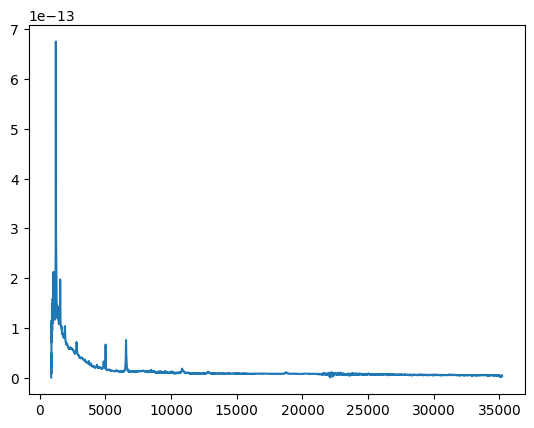

In [52]:
plt.plot(wavelength, flux)
plt.show()

In [9]:
df_clean.to_csv("../data/processed/DR16Q_v4_z2.5_sn_15.csv", index=False)